In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

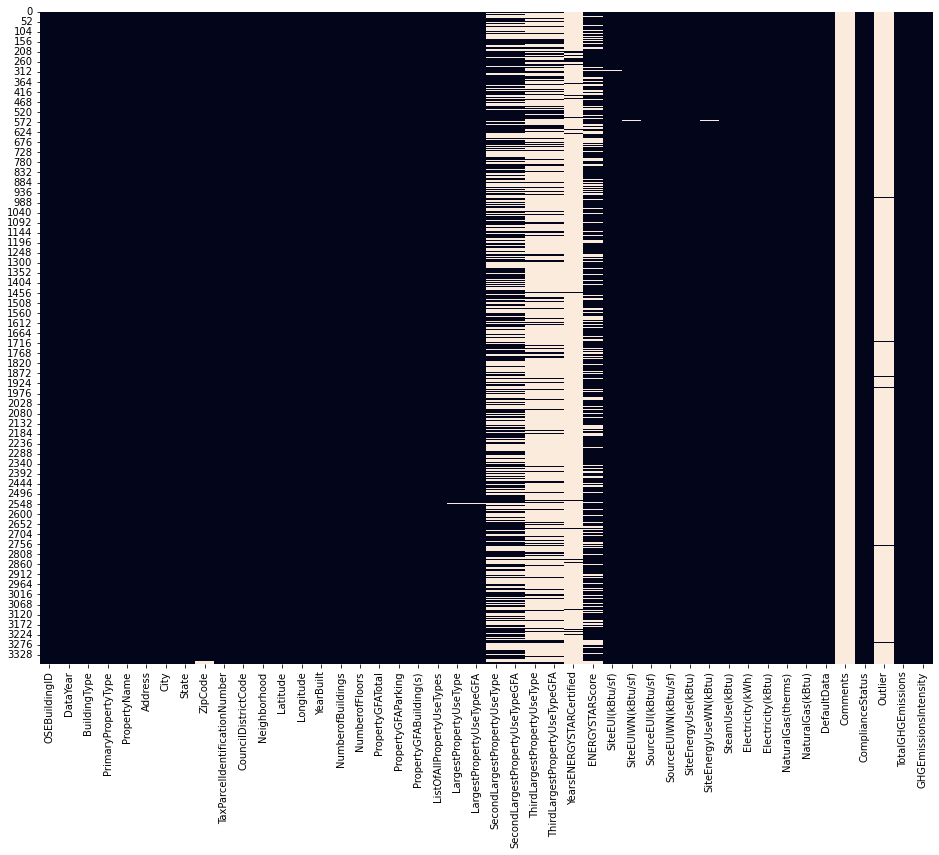

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA'] # Réflechir sur rajouter ou non Campus comme building résidentiel,'Campus','SPS-District K-12',

nonResidential = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonResidential = nonResidential[nonResidential['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonResidential.shape

(1432, 46)

In [19]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [20]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)

In [21]:
nonResidential = nonResidential.drop(nonResidential[nonResidential['PrimaryPropertyType'] == 'Residence Hall'].index)

In [22]:
nonResidential.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     38
Medical Office                  38
Self-Storage Facility           28
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [23]:
nonResidential.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        633
SecondLargestPropertyUseTypeGFA     633


In [24]:
nonResidential['ComplianceStatus'].value_counts()

Compliant    1410
Name: ComplianceStatus, dtype: int64

In [25]:
nonResidential['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [26]:
nonResidential = nonResidential[nonResidential.Outlier.isnull()]

In [27]:
nonResidential = nonResidential[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions']]

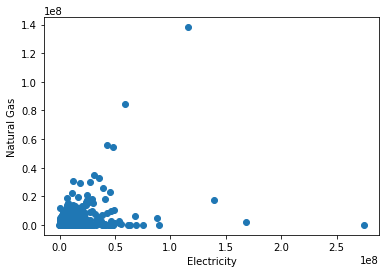

In [28]:
plt.scatter(nonResidential['Electricity(kBtu)'],nonResidential['NaturalGas(kBtu)'])
plt.xlabel('Electricity')
plt.ylabel('Natural Gas')
plt.show()

In [29]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
dtype: int64

In [30]:
nonResidential = nonResidential.dropna(axis=0) 

In [31]:
nonResidential['NumberofBuildings'].value_counts()

1.0    1329
0.0      44
2.0      11
3.0      10
6.0       4
5.0       3
4.0       2
9.0       1
7.0       1
8.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [32]:
df1 = nonResidential.copy()

In [33]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [34]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [35]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [36]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [82]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [38]:
X_train, y_train, X_test, y_test = train.drop(columns = "TotalGHGEmissions"), train["TotalGHGEmissions"],test.drop(columns = "TotalGHGEmissions") ,test["TotalGHGEmissions"]

In [39]:
r_forest = RandomForestRegressor(random_state=0)

In [40]:
# entrainement du modèle
r_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [41]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y_test,preds, squared=False))

221.9097494650815


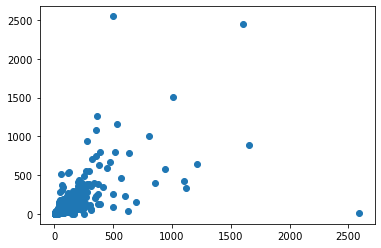

In [42]:
plt.scatter(preds,y_test)

In [43]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [44]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [45]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  260.158884  		 MAE: 168.769917  		 R2:  -0.044254
strategy: median  		 RMSE:  267.804295  		 MAE: 112.336280  		 R2:  -0.106531


In [46]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y_train, y_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  221.909749  		 MAE: 87.137054  		 R2:  0.240231
N_Estimator: 200  		 RMSE:  215.468885  		 MAE: 86.100294  		 R2:  0.283695
N_Estimator: 300  		 RMSE:  214.949087  		 MAE: 86.136948  		 R2:  0.287147
N_Estimator: 400  		 RMSE:  215.411159  		 MAE: 86.065216  		 R2:  0.284079
N_Estimator: 500  		 RMSE:  215.245067  		 MAE: 85.989506  		 R2:  0.285183


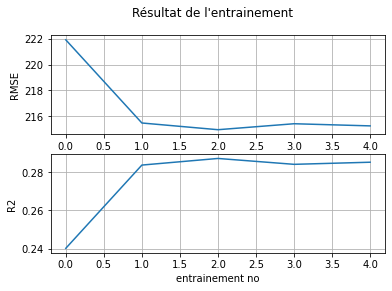

In [47]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

### - Dummy Regressor

In [48]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [49]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, scoring='r2')

In [50]:
CV_dummy_mean.best_score_

-0.04005679901373993

In [51]:
dummy_model = CV_dummy_mean.best_estimator_

In [52]:
dummy_model.score(X_test,y_test)

-0.04425357537880048

In [53]:
pd.DataFrame(CV_dummy_mean.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000803,0.000402,0.000399,0.000489,mean,{'strategy': 'mean'},-0.001422,-0.011349,-0.000008,-0.002899,-0.184606,-0.040057,0.072382,1
1,0.000798,0.000399,0.000199,0.000399,median,{'strategy': 'median'},-0.040129,-0.039824,-0.040598,-0.149748,-0.111992,-0.076458,0.046004,2


### - Random Forest Regressor


In [54]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [84]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X_train, y_train)

KeyboardInterrupt: 

In [56]:
CV_rfc.best_params_

{'max_depth': 16,
 'max_features': 'sqrt',
 'n_estimators': 400,
 'random_state': 12}

In [57]:
CV_rfc.best_score_

0.536332240235964

In [58]:
model = CV_rfc.best_estimator_

In [59]:
model.score(X_test,y_test)

0.4334947214171825

In [60]:
pd.DataFrame(model.feature_importances_)

,0
0,0.038548
1,0.052585
2,0.164780
3,0.047196
4,0.153842
5,0.012107
6,0.202407
7,0.027327
8,0.000338
9,0.012030


In [61]:
pd.DataFrame(CV_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.189272,0.004116,0.008103,0.000516,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.625470,0.719655,0.614819,0.317225,-0.571703,0.341093,0.475998,70
1,0.371164,0.005912,0.014138,0.000236,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.635144,0.720615,0.660036,0.309612,-0.635357,0.338010,0.507272,72
2,0.552933,0.006370,0.020918,0.000828,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.636532,0.718740,0.642371,0.319910,-0.501523,0.363206,0.453580,54
3,0.742904,0.003558,0.028315,0.001230,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.653722,0.717415,0.647109,0.337499,-0.519182,0.367313,0.462526,53
4,0.872036,0.010180,0.032370,0.000773,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.651537,0.713771,0.623223,0.317003,-0.541972,0.352713,0.467883,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.199744,0.003815,0.011673,0.000390,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.646568,0.609544,0.709715,0.266836,0.309095,0.508352,0.183261,37
71,0.395852,0.006863,0.022690,0.001920,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.681653,0.625874,0.691803,0.301150,0.325711,0.525238,0.174565,13
72,0.600959,0.018449,0.032929,0.001700,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.660814,0.616355,0.688580,0.276602,0.368565,0.522183,0.167143,17
73,0.798821,0.016371,0.041784,0.001377,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.668244,0.609000,0.689135,0.302162,0.374421,0.528592,0.159237,7


### - Ridge Regressor

In [62]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [63]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]},
             scoring='r2')

In [64]:
CV_ridge.best_score_

0.3407824018929184

In [65]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=5)


In [66]:
model_ridge.score(X_test,y_test)

-0.014194216940971671

In [67]:
pd.DataFrame(CV_ridge.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003882,0.001379,0.002168,0.000741,0.001,{'alpha': 0.001},0.570410,0.753518,0.749073,0.746735,0.064984,-2.007933,0.146131,0.993292,7
1,0.004066,0.001319,0.001761,0.001119,0.01,{'alpha': 0.01},0.569886,0.753210,0.748964,0.746989,0.066067,-1.996767,0.148058,0.989187,6
2,0.003808,0.001336,0.001672,0.000452,0.1,{'alpha': 0.1},0.564709,0.750152,0.747894,0.749069,0.076112,-1.890429,0.166251,0.950066,5
3,0.003423,0.000918,0.002125,0.000809,1,{'alpha': 1},0.517648,0.721361,0.738540,0.754627,0.124204,-1.186916,0.278244,0.690761,4
4,0.002927,0.000741,0.002811,0.001189,2,{'alpha': 2},0.474362,0.693970,0.730191,0.752104,0.124176,-0.814814,0.326665,0.554457,2
5,0.003313,0.001217,0.001846,0.001038,5,{'alpha': 5},0.386667,0.636408,0.712690,0.737414,0.057258,-0.485742,0.340782,0.437543,1
6,0.003703,0.000892,0.001623,0.000445,10,{'alpha': 10},0.313668,0.584905,0.695222,0.718277,-0.040677,-0.462347,0.301508,0.430065,3


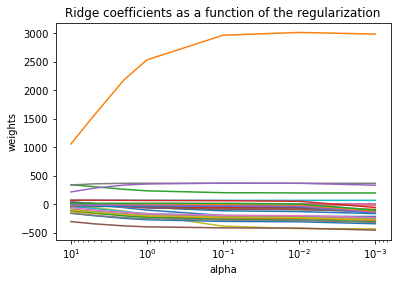

In [68]:
alphas = [1e-3, 1e-2, 1e-1, 1, 2, 5, 10]
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

### - KNN Regressor

In [69]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [70]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             scoring='r2')

In [71]:
CV_knn.best_score_

0.18196926551964598

In [72]:
model_knn = CV_knn.best_estimator_

In [73]:
model_knn.score(X_test,y_test)

0.2882577166312903

In [74]:
CV_knn.best_params_

{'n_neighbors': 83}

In [75]:
pd.DataFrame(CV_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002498,0.000758,0.006310,0.001481,10,{'n_neighbors': 10},-0.366769,0.205108,0.199720,0.184808,-0.446444,-0.960955,-0.197422,0.435799,90
1,0.002779,0.000935,0.006485,0.000608,11,{'n_neighbors': 11},-0.271130,0.340611,0.206266,0.217852,-0.284844,-0.993698,-0.130824,0.455598,89
2,0.002782,0.000993,0.005315,0.001259,12,{'n_neighbors': 12},-0.186538,0.380029,0.197746,0.212066,-0.190186,-1.021079,-0.101327,0.461964,88
3,0.002213,0.000949,0.006181,0.001041,13,{'n_neighbors': 13},-0.132170,0.363137,0.182838,0.240785,-0.099414,-0.955978,-0.066800,0.435459,85
4,0.002411,0.000907,0.006450,0.001034,14,{'n_neighbors': 14},-0.153340,0.384407,0.181338,0.247592,-0.002643,-0.997892,-0.056756,0.454961,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.002837,0.001211,0.006964,0.000997,95,{'n_neighbors': 95},0.197521,0.222089,0.099148,0.162454,0.329579,0.069206,0.180000,0.085218,13
86,0.002333,0.000464,0.006790,0.001039,96,{'n_neighbors': 96},0.196408,0.220029,0.098027,0.161658,0.327939,0.071790,0.179309,0.084182,18
87,0.002583,0.000943,0.007609,0.001537,97,{'n_neighbors': 97},0.195042,0.219115,0.096983,0.160586,0.329854,0.076451,0.179672,0.083868,16
88,0.002619,0.000921,0.007718,0.002186,98,{'n_neighbors': 98},0.195158,0.217751,0.096040,0.159512,0.327855,0.077269,0.178931,0.083198,19


### - XGBoost

In [76]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [77]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             scoring='r2')

In [78]:
CV_xgboost.best_score_

0.518067493402039

In [79]:
model_boosted = CV_xgboost.best_estimator_

In [80]:
model_boosted.score(X_test,y_test)

0.4383364140955366

In [81]:
pd.DataFrame(CV_xgboost.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.223605,0.021519,0.002517,0.000439,4,auto,100,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.690948,0.783470,0.091270,0.397428,-0.139992,0.364625,0.349959,51
1,0.450525,0.023284,0.003366,0.000802,4,auto,200,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.693497,0.782735,0.093285,0.362391,-0.140516,0.358278,0.349734,52
2,0.638276,0.004587,0.002603,0.001212,4,auto,300,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.697910,0.783805,0.093397,0.356157,-0.159443,0.354365,0.356244,55
3,0.852060,0.022501,0.004573,0.000791,4,auto,400,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.698345,0.784632,0.094079,0.357807,-0.154914,0.355990,0.355124,53
4,1.041666,0.021639,0.004211,0.000744,4,auto,500,12,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.698051,0.785725,0.092987,0.357750,-0.155255,0.355852,0.355590,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,0.203175,0.005809,0.005906,0.000502,64,log2,100,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.658938,0.567129,0.682272,0.176083,0.108830,0.438651,0.245808,41
71,0.398522,0.012421,0.010112,0.000665,64,log2,200,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.658938,0.567143,0.682281,0.176056,0.108812,0.438646,0.245822,43
72,0.455097,0.004900,0.010691,0.000626,64,log2,300,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.658938,0.567143,0.682281,0.176056,0.108812,0.438646,0.245822,45
73,0.466241,0.010716,0.010371,0.000983,64,log2,400,12,"{'max_depth': 64, 'max_features': 'log2', 'n_e...",0.658938,0.567143,0.682281,0.176056,0.108812,0.438646,0.245822,45
